In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import mne
import torch.nn.functional as F
import datetime
from torch.utils.data import TensorDataset, DataLoader, random_split, WeightedRandomSampler

In [28]:
# Load the data
try:
    data = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\openvibe\processed\2024-06-11_20-19-41\dataset_2024-06-11_20-19-41.pt")
    label = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\openvibe\processed\2024-06-11_20-19-41\labels_2024-06-11_20-19-41.pt")
except FileNotFoundError:
    print("File not found. Please check the path.")
    raise

# Create a dataset and dataloaders
dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long))

# Ensure reproducibility
torch.manual_seed(42)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Check if the data is loaded correctly
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")

Number of training samples: 104
Number of validation samples: 26


C:\Users\chakr\AppData\Local\Temp\ipykernel_13252\2011524877.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long))


In [13]:
# # 2 datasets with different weights
# # Load the first dataset and labels
# try:
#     data1 = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\2024-06-11_14-23-47\dataset_2024-06-11_14-23-47.pt")
#     label1 = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\2024-06-11_14-23-47\labels_2024-06-11_14-23-47.pt")
# except FileNotFoundError:
#     print("File 1 not found. Please check the path.")
#     raise

# # Load the second dataset and labels
# try:
#     data2 = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\another_date\dataset_another_date.pt")
#     label2 = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\another_date\labels_another_date.pt")
# except FileNotFoundError:
#     print("File 2 not found. Please check the path.")
#     raise

# # Combine the datasets and labels
# data = torch.cat((data1, data2), dim=0)
# labels = torch.cat((label1, label2), dim=0)

# # Create a dataset
# dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))

# # Ensure reproducibility
# torch.manual_seed(42)

# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# # Create weights for the sampler to make the model more specific to one of the datasets
# # Assume we want to make the model more specific to dataset1
# weights = np.concatenate((
#     np.ones(len(data1)) * 0.8,  # weight 0.8 for dataset1
#     np.ones(len(data2)) * 0.2   # weight 0.2 for dataset2
# ))

# # Create a weighted random sampler
# sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# # Create dataloaders
# train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Check if the data is loaded correctly
# print(f"Number of training samples: {len(train_loader.dataset)}")
# print(f"Number of validation samples: {len(val_loader.dataset)}")

In [2]:
# class Advanced_EEG_MI_CNN(nn.Module):
#     def __init__(self):
#         super(Advanced_EEG_MI_CNN, self).__init__()
#         # First convolutional layer with Batch Normalization and ReLU activation
#         self.conv1 = nn.Conv2d(in_channels=25, out_channels=32, kernel_size=(3, 3), padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.pool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        
#         # Second convolutional layer with Batch Normalization and ReLU activation
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.pool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        
#         # Third convolutional layer with Batch Normalization and ReLU activation
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.pool3 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        
#         # Dropout layer to prevent overfitting
#         self.dropout = nn.Dropout(p=0.5)
        
#         # Use a dummy input to determine the size of the fully connected layer input
#         dummy_input = torch.zeros(1, 25, 43, 1251)
#         dummy_output = self._forward_conv_layers(dummy_input)
#         fc_input_size = dummy_output.numel()  # Total number of elements in the output
        
#         self.fc1 = nn.Linear(fc_input_size, 256)
#         self.fc2 = nn.Linear(256, 64)
#         self.fc3 = nn.Linear(64, 2)  # Assuming 2 classes for binary classification

#     def _forward_conv_layers(self, x):
#         # Forward pass through the first convolutional layer
#         x = self.pool1(F.relu(self.bn1(self.conv1(x))))
#         # Forward pass through the second convolutional layer
#         x = self.pool2(F.relu(self.bn2(self.conv2(x))))
#         # Forward pass through the third convolutional layer
#         x = self.pool3(F.relu(self.bn3(self.conv3(x))))
#         return x

#     def forward(self, x):
#         # Forward pass through the convolutional layers
#         x = self._forward_conv_layers(x)
#         # Flatten the tensor to feed into fully connected layers
#         x = x.view(x.size(0), -1)
#         # Forward pass through the first fully connected layer with ReLU and dropout
#         x = self.dropout(F.relu(self.fc1(x)))
#         # Forward pass through the second fully connected layer with ReLU
#         x = F.relu(self.fc2(x))
#         # Output layer
#         x = self.fc3(x)
#         return x

In [3]:
class Advanced_EEG_MI_CNN(nn.Module):
    def __init__(self):
        super(Advanced_EEG_MI_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.dropout = nn.Dropout(p=0.5)
        
        # Compute the size of the input to the fully connected layer
        dummy_input = torch.zeros(1, 8, 43, 1251)
        dummy_output = self._forward_conv_layers(dummy_input)
        fc_input_size = dummy_output.numel()
        
        self.fc1 = nn.Linear(fc_input_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)

    def _forward_conv_layers(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
class Advanced_EEG_MI_CNN_LSTM_Transformer(nn.Module):
    def __init__(self):
        super(Advanced_EEG_MI_CNN_LSTM_Transformer, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=128*6*157, hidden_size=128, num_layers=1, batch_first=True)
        
        # Transformer layer
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
    def _forward_conv_layers(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        batch_size = x.size(0)
        # Forward pass through convolutional layers
        x = self._forward_conv_layers(x)
        
        # Flatten for LSTM
        x = x.view(batch_size, -1, 128*6*157)
        
        # Forward pass through LSTM
        x, (hn, cn) = self.lstm(x)
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # Take the output from the last sequence step for classification
        x = x[:, -1, :]
        
        # Forward pass through fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
# Define a function to save the model with the date and time in the filename
def save_model(model, path):
    try:
        torch.save(model.state_dict(), path)
        print(f'Model saved as {path}')
    except Exception as e:
        print(f'Error saving the model: {e}')

# Example usage:
model = Advanced_EEG_MI_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Save the model with the current date and time
current_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_dir = r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\openvibe\models"
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, f'{model.__class__.__name__}_{current_time}.pth')
save_model(model, model_filename)

In [5]:
# Load the saved model
model_path = r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\models\Advanced_EEG_MI_CNN_2024-06-11_20-18-14.pth"
model = Advanced_EEG_MI_CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

# Load unseen data
try:
    unseen_data = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\2024-06-11_18-56-57\dataset_2024-06-11_18-56-57.pt")
    unseen_labels = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\2024-06-11_18-56-57\labels_2024-06-11_18-56-57.pt")
except FileNotFoundError:
    print("File not found. Please check the path.")
    raise

# Create a dataset and dataloader for the unseen data
unseen_dataset = TensorDataset(torch.tensor(unseen_data, dtype=torch.float32), torch.tensor(unseen_labels, dtype=torch.long))
unseen_loader = DataLoader(unseen_dataset, batch_size=32, shuffle=False)

# Evaluate the model on unseen data
correct = 0
total = 0
criterion = nn.CrossEntropyLoss()
unseen_loss = 0.0

with torch.no_grad():
    for inputs, labels in unseen_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        unseen_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

unseen_loss = unseen_loss / len(unseen_loader.dataset)
unseen_accuracy = correct / total
print(f'Unseen Data Loss: {unseen_loss:.4f}, Unseen Data Accuracy: {unseen_accuracy:.4f}')

C:\Users\chakr\AppData\Local\Temp\ipykernel_17096\3054402893.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unseen_dataset = TensorDataset(torch.tensor(unseen_data, dtype=torch.float32), torch.tensor(unseen_labels, dtype=torch.long))


Unseen Data Loss: 0.1854, Unseen Data Accuracy: 0.9429


C:\Users\chakr\AppData\Local\Temp\ipykernel_17096\751244196.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unseen_dataset = TensorDataset(torch.tensor(unseen_data, dtype=torch.float32), torch.tensor(unseen_labels, dtype=torch.long))


Unseen Data Loss: 0.1854, Unseen Data Accuracy: 0.9429
Precision: 0.9432, Recall: 0.9429, F1 Score: 0.9429


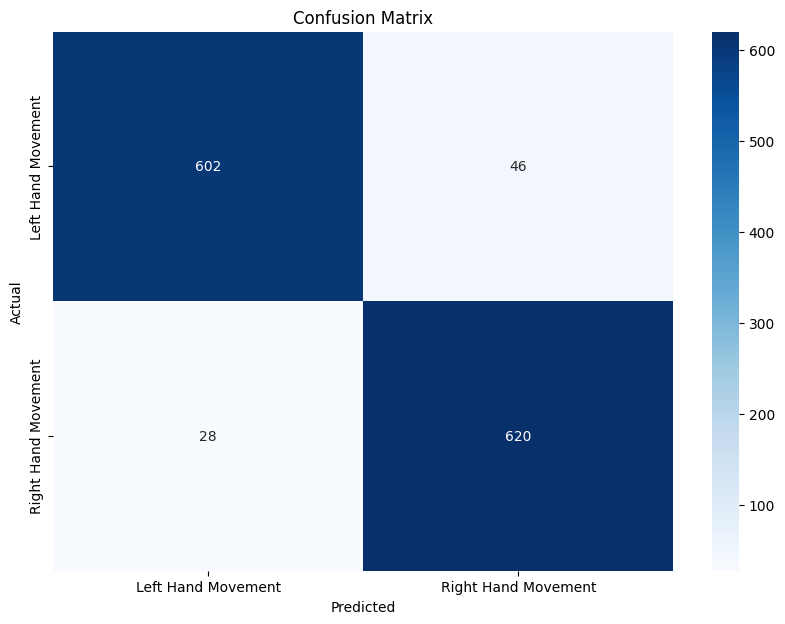

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model_path = r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\models\Advanced_EEG_MI_CNN_2024-06-11_20-18-14.pth"
model = Advanced_EEG_MI_CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

# Load unseen data
try:
    unseen_data = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\2024-06-11_18-56-57\dataset_2024-06-11_18-56-57.pt")
    unseen_labels = torch.load(r"C:\School\EE_Y3\Q4\BAP\eeg_thesis_cnn_repo\data\bcic_iv_2a\processed\2024-06-11_18-56-57\labels_2024-06-11_18-56-57.pt")
except FileNotFoundError:
    print("File not found. Please check the path.")
    raise

# Create a dataset and dataloader for the unseen data
unseen_dataset = TensorDataset(torch.tensor(unseen_data, dtype=torch.float32), torch.tensor(unseen_labels, dtype=torch.long))
unseen_loader = DataLoader(unseen_dataset, batch_size=32, shuffle=False)

# Evaluate the model on unseen data
correct = 0
total = 0
criterion = nn.CrossEntropyLoss()
unseen_loss = 0.0

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in unseen_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        unseen_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Compute metrics
unseen_loss = unseen_loss / len(unseen_loader.dataset)
unseen_accuracy = correct / total
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'Unseen Data Loss: {unseen_loss:.4f}, Unseen Data Accuracy: {unseen_accuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Confusion Matrix Visualization
class_names = ['Left Hand Movement', 'Right Hand Movement']
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
